## Modeling Tutorial

In [11]:
### Import packages
import polars as pl
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import itertools
from collections import Counter

# For plotting
import seaborn as sns

sns.set_theme(style="ticks")
sns.axes_style("darkgrid")
sns.set_theme()

from IPython.display import display, HTML

# For storing DataFrames
import pickle

import sys
from os import getcwd
sys.path.append(getcwd())
import MultiStagePackage.OptMSPfunctions as msp
from MultiStagePackage.models import *

from itertools import islice
import collections
from ast import literal_eval

# For optimization
from pygmo import *

### Model design

The following models below show how you can modify the provided models (the comments with 'ADD' show what was changed):

#### Models:
- Second product (```P2```)
- Second substrate (```S2```)
- Oxygen **only** in the second model (```O_2```) 

In [22]:
### Prepare data

## Models
# Taken from models.py 

def model1(t, y):
    # Measurement-based parameters: 
    mu  = 0.13
    r_S = 16.13
    r_P = 26.11
    r_S2 = 15.00                # ADD new substrates reaction coefficient
    r_P2 = 2.0                  # ADD new product reaction coefficient
    r_O_2 = 0.0                 # ADD oxygen reaction coefficient

    # Check for values smaller 0
    for i in range(len(y)):
        if(y[i]<0.0):
            y[i] = 0.0

    if(y[S]>0.001): 
        dXdt =   mu*y[X]
        dSdt = - r_S*y[X]
        dPdt =   r_P*y[X]
        dS2dt = - r_S2*y[X]       # ADD the second substrate to the ODE model
        dP2dt =  r_P2*y[X]        # ADD the second product to the ODE model
        dO_2dt = r_O_2*y[X]       # ADD oxygen to the ODE model
    
    # Case in which substrate was all taken up
    else:
        dXdt = 0
        dSdt = 0
        dPdt = 0
        dS2dt = 0               # ADD 
        dP2dt = 0               # ADD 
        dO_2dt = 0             # ADD 

    if(dXdt<0.0):
        print(dXdt)
    
    dydt = [dXdt, dSdt, dPdt, dS2dt, dP2dt, dO_2dt]     # ADD
    return(dydt)

def model2(t, y):
    # Measurement-based parameters:
    mu  = 0.06
    r_S = 22.86
    r_P = 41.25  
    r_S2 = 30.00                # ADD new substrates reaction coefficient
    r_P2 = 10.0                 # ADD new product reaction coefficient
    r_O_2 = 2.0                 # ADD oxygen reaction coefficient 

    # Check for values smaller 0
    for i in range(len(y)):
        if(y[i]<0.0):
            y[i] = 0.0

    if(y[S]>0.001):
        dXdt =   mu*y[X]
        dSdt = - r_S*y[X]
        dPdt =   r_P*y[X]
        dS2dt = -r_S2*y[X]       # ADD the species in ODE model
        dP2dt =  r_P2*y[X]       # ADD the species in ODE model
        dO_2dt = r_O_2*y[X]      # ADD oxygen to the ODE model

    else:
        dXdt = 0
        dSdt = 0
        dPdt = 0
        dS2dt = 0               # ADD
        dP2dt = 0               # ADD
        dO_2dt = 0             # ADD
    if(dXdt<0.0):
        print(dXdt)
    
    dydt = [dXdt, dSdt, dPdt, dS2dt,dP2dt,dO_2dt]      # ADD
    return(dydt)


models = [model1, model2]

## initial conditions
X_0 = 0.1    # gDW/L
S_0 = 100.0  # mmol/L 
P_0 = 0.0    # mmol/L

S2_0 = 500                      # ADD 
P2_0 = 700                      # ADD
O_2_0 = 0.0                     # ADD

s = np.array([X_0, S_0, P_0, S2_0, P2_0, O_2_0])     # ADD

## Indexing
X, S, P, S2, P2, O_2 = (i for i in range(len(s)))    # ADD

### Event definition

In [27]:
def event_sub0(t,y):
    if(y[S] <= 0.001):
        return 0    # 0 that event triggers
    return 1

### Test integration

In [23]:
%%time
times = [0, 1]  # Input time points
combi = [0, 1]   # Models
s = np.array([X_0, S_0, P_0, S2_0, P2_0, O_2_0])

# Test model1
result_num = sp.integrate.solve_ivp(models[int(combi[0])],t_span=[times[0], times[1]],y0=s,t_eval=[times[1]],dense_output=True,max_step=0.01,).y.T
print(result_num[0])

# Test model2
result_num = sp.integrate.solve_ivp(models[int(combi[1])],t_span=[times[0], times[1]],y0=s,t_eval=[times[1]],dense_output=True,max_step=0.01,).y.T
print(result_num[0])

[1.13882838e-01 9.82774601e+01 2.78831468e+00 4.98398134e+02
 7.00213582e+02 0.00000000e+00]
[1.06183655e-01 9.76440276e+01 4.25126257e+00 4.96908173e+02
 7.01030609e+02 2.06121822e-01]
CPU times: user 10 ms, sys: 5.68 ms, total: 15.7 ms
Wall time: 15.1 ms


### Test BruteForce

In [28]:
t_start = 0
t_end = 24
min_duration = 5
n_stages = 2
combis = list(itertools.product([0, 1], [0, 1]))  
den=4

MSP_2Stage = msp.do_brute_force_num(combis=combis,                  # list of combinations to test
                                    models=models,                  # list with model functions
                                    n_stages=n_stages,              # maximum of stages to test
                                    t_start=t_start,                # start time
                                    t_end=t_end,                    # end time
                                    min_duration=min_duration,      # minimal duration of one phase
                                    s=s,                            # initial values of species
                                    events=[event_sub0],            # event function for denoting real end time of fermentation (here when no substrate is present anymore; in other use cases different)
                                    density=den,                    # density or step time (how frequent the switching times are sampled -> see for more information OptMSP_SupportFunctions.ipynb notebook)
                                    indexes=[X, S, P])              # indexes 

display(MSP_2Stage.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:5])

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
72,73,"(0.0, 10.75, 24.0)","[1, 2]",16.402,0.568,0.001,173.427,2,10.574,1.734,1.734
1,2,"(0.0, 5.25, 24.0)","[1, 1]",16.952,0.906,0.001,161.871,2,9.549,1.619,1.619
98,99,"(0.0, 5.0, 24.0)","[2, 1]",19.004,0.833,0.001,164.347,2,8.648,1.643,1.643
185,186,"(0.0, 12.5, 24.0)","[2, 2]",21.463,0.362,0.001,180.445,2,8.407,1.804,1.804


### Test Optimizer

In [29]:
## 1.) Volumetric productivity
def volprod(simulation, indexes, initial_values, tstart, tend):
    return simulation[P]/(simulation[-2]-tstart)

## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(ihs(gen=100, seed=12345))  
algo_ihs.set_verbosity(50)  # output best performing each 50th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
problem_sim_volP = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,                                # initial values of species
            models=models,                      # list of functions of the models 
            indexes=[X, S, P],                  # indexes to denote at which position in the model are biomass, substrate and product (default is [0,1,2]; -> see for more information ModelingTutorial.ipynb notebook)
            tstart=0,                           # start time of process
            tend=24,                            # end time of process
            max_stage=2,                        # The maximum stages the user wants to test out (optimal solution might turn out to not have as many stages)
            min_duration=1,                     # minimal duration of each sub-process/module
            objective=volprod,                  # Objective function 
            optmod="max",                       # Maximization or minimization? ("max" or "min")
            calc_option=msp.numeric_option,     # Numeric models as imput
            events=[event_sub0],                # event function for denoting real end time of fermentation (here when no substrate is present anymore; in other use cases different)
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
# Define a relative tolerance that 
problem_sim_volP.c_tol = 1e-3

## 4.) Starting the optimization
res_opt = algo_ihs.evolve(population(problem_sim_volP, size=10, seed=12345))  # start with 10 candidate solutions


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1         0.3564       0.891251        2.81321        1.39567              0              0       -9.54854
     51         0.6764     0.00281838        15.8693    1.26135e-05              0              0       -9.54855


In [30]:
# 1) Extract the log out of the optimization object (we exclude the first row since this is a initialization row and does not have the same format as the other rows):
log = pd.DataFrame(res_opt.problem.extract(decorator_problem).dv_log)[1:] 

# 2) Do extraction for the number of best combinations you choose:
best_res = msp.do_opt_to_df(  df=log,     # log dataframe from optimization
                                n_best=1)  # Number of best performing processes that are returned

# 3) Convert the solutions from best_res_num into the same format as in the brute force solution dataframe:
df=msp.do_convert(opt_res=best_res,             # Output from do_opt_to_df()
                    models_num=models,          # models (in numeric form)
                    t_start=0, 
                    t_end=20, 
                    s=s, 
                    events=[event_sub0], 
                    indexes=[X, S, P])

No constraints found.


In [31]:
df

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 7.989, 20.0]","[1, 2]",17.015,0.486,0.0,176.239,2,10.358,1.762,1.762


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or var

<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

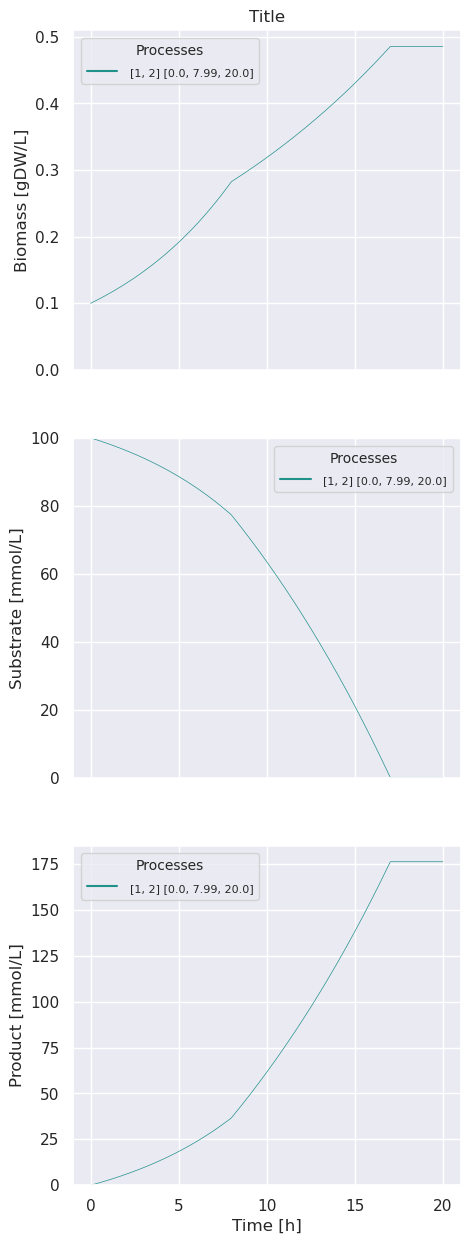

In [32]:
msp.do_custom_plot(df=df, 
                   models_num=models, 
                   s=s, 
                   title="Title",
                   events=[event_sub0],
                   indexes=[X,S,P])

### Change the yield calculations and plotting to substrate 2 and product 2

Also if you want make the end of integration (the event function) now dependent on substrate 2

In [34]:
def event_sub0_2(t,y):
    if(y[S2] <= 0.001): # <- CHANGE HERE THE INDEX
        return 0    
    return 1

t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
combis = list(itertools.product([0, 1], [0, 1]))  
den=4

MSP_2Stage = msp.do_brute_force_num(combis=combis,                  
                                    models=models,               
                                    n_stages=n_stages,           
                                    t_start=t_start,          
                                    t_end=t_end,         
                                    min_duration=min_duration,   
                                    s=s,                         
                                    events=[event_sub0_2],           
                                    density=den,                
                                    indexes=[X, S2, P2]) # <- CHANGE HERE THE INDEXES 

display(MSP_2Stage.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:5])

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
355,356,"(0.0, 23.0, 24.0)","[2, 2]",24.0,0.362,368.768,743.744,inf,30.989,1.487,5.667
265,266,"(0.0, 22.75, 24.0)","[2, 1]",24.0,0.362,368.768,743.744,inf,30.989,1.487,5.667
89,90,"(0.0, 1.0, 24.0)","[1, 2]",24.0,0.372,369.426,743.204,inf,30.967,1.486,5.692
1,2,"(0.0, 1.25, 24.0)","[1, 1]",24.0,0.906,407.006,712.399,inf,29.683,1.425,7.661


In [40]:
## 1.) 
def volprod(simulation, indexes, initial_values, tstart, tend):
    return simulation[P2]/(simulation[-2]-tstart)                    # <- CHANGE HERE THE INDEX

## 2.) 
algo_ihs = algorithm(ihs(gen=1000, seed=12345))  
algo_ihs.set_verbosity(50)  

## 3.) 
problem_sim_volP = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,                                
            models=models,                      
            indexes=[X, S2, P2], # <- CHANGE HERE THE INDEXES                 
            tstart=0,                         
            tend=24,                            
            max_stage=2,                       
            min_duration=1,         
            objective=volprod,             
            optmod="max",                     
            calc_option=msp.numeric_option,    
            events=[event_sub0_2],      # <- CHANGE HERE FUNCTION       
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
 
problem_sim_volP.c_tol = 1e-3

## 4.) 
res_opt = algo_ihs.evolve(population(problem_sim_volP, size=10, seed=12345))  

log = pd.DataFrame(res_opt.problem.extract(decorator_problem).dv_log)[1:] 
best_res = msp.do_opt_to_df(  df=log,     
                                n_best=1) 
df=msp.do_convert(opt_res=best_res,
                    models_num=models,
                    t_start=0, 
                    t_end=20, 
                    s=s, 
                    events=[event_sub0_2],  # <- CHANGE HERE FUNCTION
                    indexes=[X, S2, P2])     # <- CHANGE HERE THE INDEXES   


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1        0.35064       0.988553        15.5613        1.30604              0              0       -30.9893
     51        0.38264       0.555904        15.1325    3.75279e-06              0              0       -30.9893
    101        0.41464       0.312608        10.4275    5.46369e-06              0              0       -30.9893
    151        0.44664       0.175792              0              0              0              0       -30.9893
    201        0.47864      0.0988553              0              0              0              0       -30.9893
    251        0.51064      0.0555904              0              0              0              0       -30.9893
    301        0.54264      0.0312608              0              0              0              0       -30.9893
    351        0.57464      0.0175792       0.308301    4.97381e-07              0             

In [41]:
df

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 14.306, 20.0]","[2, 2]",20.0,0.332,383.994,738.669,inf,36.933,1.477,6.368


### Change objective function to yield

In [42]:
t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
combis = list(itertools.product([0, 1], [0, 1]))  
den=4

MSP_2Stage = msp.do_brute_force_num(combis=combis,                  
                                    models=models,               
                                    n_stages=n_stages,           
                                    t_start=t_start,          
                                    t_end=t_end,         
                                    min_duration=min_duration,   
                                    s=s,                         
                                    events=[event_sub0],           
                                    density=den,                
                                    indexes=[X, S, P]) 

## Change in Brute force only the way you filter the end dataframe (here now filtered after yield (Y_SubInput)): 
display(MSP_2Stage.sort_values(["Y_SubInput"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:5])

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
295,296,"(0.0, 21.5, 24.0)","[2, 2]",21.463,0.362,0.001,180.445,1,8.407,1.804,1.804
212,213,"(0.0, 21.5, 24.0)","[2, 1]",21.463,0.362,0.001,180.445,1,8.407,1.804,1.804
65,66,"(0.0, 1.0, 24.0)","[1, 2]",20.721,0.372,0.001,180.125,2,8.693,1.801,1.801
22,23,"(0.0, 6.5, 24.0)","[1, 1]",16.952,0.906,0.001,161.871,2,9.549,1.619,1.619


In [43]:
## 1.) 
def product_yield(simulation, indexes, initial_values, tstart, tend):   # HERE NEW OBJECTIVE FUNCTION
    return simulation[P]/(initial_values[S]-simulation[S])              

## 2.) 
algo_ihs = algorithm(ihs(gen=1000, seed=12345))  
algo_ihs.set_verbosity(50)  

## 3.) 
problem_sim_volP = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,                                
            models=models,                      
            indexes=[X, S, P],     
            tstart=0,                         
            tend=24,                            
            max_stage=2,                       
            min_duration=1,         
            objective=product_yield,    # <- HERE ADD NEW OBJECTIVE FUNCTION     
            optmod="max",                     
            calc_option=msp.numeric_option,    
            events=[event_sub0],            
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
problem_sim_volP.c_tol = 1e-3

## 4.) 
res_opt = algo_ihs.evolve(population(problem_sim_volP, size=10, seed=12345))  

log = pd.DataFrame(res_opt.problem.extract(decorator_problem).dv_log)[1:] 
best_res = msp.do_opt_to_df(  df=log,     
                                n_best=1) 
df=msp.do_convert(opt_res=best_res,
                    models_num=models,
                    t_start=0, 
                    t_end=20, 
                    s=s, 
                    events=[event_sub0], 
                    indexes=[X, S2, P2])     # <- CHANGE HERE THE INDEXES   
df


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1        0.35064       0.988553        7.29266       0.185739              0              0       -1.80446
     51        0.38264       0.555904        6.12079    4.21885e-15              0              0       -1.80446
    101        0.41464       0.312608              0              0              0              0       -1.80446
    151        0.44664       0.175792              0              0              0              0       -1.80446
    201        0.47864      0.0988553              0              0              0              0       -1.80446
    251        0.51064      0.0555904              0              0              0              0       -1.80446
    301        0.54264      0.0312608              0              0              0              0       -1.80446
    351        0.57464      0.0175792              0              0              0             

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 3.223, 20.0]","[2, 2]",20.0,0.332,383.994,738.669,inf,36.933,1.477,6.368


For other possible implementations of models and corresponding optimizations see the case studies:

- CaseStudy_gotsmy2023: Optimization for volumetric productivity in a fed batch setup
- CaseStudy_klamt2018: Optimization for volumetric productivity with yield constraint (also incorporates the option with auxiliary variables!)
- CaseStudy_wichmann2023: Optimization for volumetric productivity with 3-stage implementation

